# Gridding lots of map data

Goal: generate a regularly-sampled raster dataset of rippability estimates.

The raw rippability estimates come from water wells, which are scattered irregularly across the map. Generating a regularly-sampled raster is therefore an interpolation problem.

[Previous tests](./data/rippability_interpolation.ipynb) based on [Matt Hall's example](https://github.com/agile-geoscience/xlines/blob/master/notebooks/11_Gridding_map_data.ipynb) showed good results from the [scipy.interpolate radial basis function (Rbf)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html) method, especially with the 'gaussian' option. But trying to run Rbf with 82,299 input points gives an error like this:

```
MemoryError: Unable to allocate 50.5 GiB for an array with shape (82299, 82299) and data type float64
```

This is clearly not scalable: for $ N $ points, the memory requirement is $ N^2 $! Why does it need to be one big matrix problem?

Let's try another strategy, similar to Gaussian [kernel smoothing](https://en.wikipedia.org/wiki/Kernel_smoother). The smoothed value for a given *output* point $ X_0 $ is

$$ Y(X_0) = \frac{\sum_{i=1}^N K(X_0, X_i) Y(X_i)}{\sum_{i=1}^N K(X_0, X_i)} $$

where $ K(X_0, X_i) $ is the Gaussian kernel

$$ K(X_0, X_i) = \exp \left( - \frac{(X_i - X_0)^2}{2 b^2} \right) $$

For efficiency, we can assume the kernel is truncated beyond some finite distance, i.e., ... TODO. We therefore need 3 things:
1. A distance function to compute meaningful values $ (X_i - X_0) $. The coordinates of each $ X $ are assumed to be (longitude, latitude) pairs
2. A kernel function to return the value of the Gaussian kernel $ K $, given a distance $ (X_i - X_0) $ and width parameter $ b $
3. A grid of output points on which to compute the interpolated values
4. An index calculation, to find the range of output points $ X_0 $ to which a given point $ X_i $ will contribute
5. A master function to loop over input points, accumulate weighted sums on the output points, and normalize the final outputs by the accumulated weights

## Kernel and Distance functions

In [3]:
import numpy

In [188]:
def kernel(normdist):
    return numpy.exp(-0.5 * normdist * normdist)

In [186]:
kernel(numpy.array([-1., 0., 1., 2., 3., 4.]))

array([6.06530660e-01, 1.00000000e+00, 6.06530660e-01, 1.35335283e-01,
       1.11089965e-02, 3.35462628e-04])

In [192]:
import matplotlib.pyplot as plt

In [62]:
testwin = numpy.linspace(-4, 4, 81)

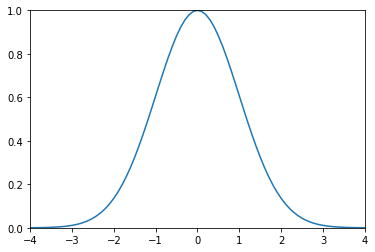

In [187]:
plt.plot(testwin, kernel(testwin))
plt.axis([-4, 4, 0, 1])
plt.show()

We use the [Havsersine formula](https://en.wikipedia.org/wiki/Haversine_formula) for distances. Note that this is a spherical Earth approximation, so it can have up to [0.5% error](https://blog.mapbox.com/fast-geodesic-approximations-with-cheap-ruler-106f229ad016). But 0.5% is more than enough accuracy for a smoothing window!

In [8]:
earth_radius = 6371008

def earth_dist(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(numpy.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = numpy.sin(dlat/2)**2 + numpy.cos(lat1) * numpy.cos(lat2) * numpy.sin(dlon/2)**2
    return 2 * earth_radius * numpy.arcsin(numpy.sqrt(a))

In [9]:
earth_dist(0, 89.5, 180, 89.5)

111195.0662708984

## Output Grid

For use in a zoomable web map, the output should be in the Web Mercator projection ([EPSG 3857](https://epsg.io/3857)). For easier tiling, we might as well choose the grid spacing to correspond to an integer zoom level. This correspondence is achieved by choosing a grid spacing equal to $ 2 \pi R_E \Big/ 2^Z N_T $, where $ R_E $ is the radius of the Earth, $ Z $ is the zoom level, and $ N_T $ is the number of pixels in a tile.

In [10]:
target_gridspace = 1000 # meters

In [11]:
tilesize = 512

In [12]:
def proj_mercator(lon, lat):
    lon, lat = map(numpy.radians, [lon, lat])
    x = earth_radius * lon
    y = earth_radius * numpy.log(numpy.tan(numpy.pi / 4 + lat / 2))
    return x, y

In [262]:
def get_mercatorX(lon):
    lon = numpy.radians(lon)
    return earth_radius * lon

In [259]:
def get_mercatorY(lat):
    lat = numpy.radians(lat)
    exp_y = numpy.tan(numpy.pi / 4 + lat / 2)
    return earth_radius * numpy.log(exp_y)

In [13]:
proj_mercator(1, 1)

(111195.0662708989, 111200.71202654958)

Solving for the zoom level, we have
$$ dg = \frac{2 \pi R_E}{2^Z N_T} \implies 2^Z = \frac{2 \pi R_E}{N_T dg} \implies Z = \log_2 \frac{2 \pi R_E}{N_T dg} $$

In [14]:
def get_zoom(dg):
    z = numpy.log2(2 * numpy.pi * earth_radius / tilesize / dg)
    return numpy.round(z)

In [15]:
maxzoom = get_zoom(target_gridspace)

Converting back into the exact gridspace gives

In [16]:
dg = 2 * numpy.pi * earth_radius / tilesize / 2 ** maxzoom

In [17]:
dg

1221.6254839332153

Note that under the usual web map tiling system, there is no pixel centered at (0, 0). The four pixels nearest (0, 0) would have coordinates $ ( \pm dg / 2, \pm dg / 2 ) $. 

Next, find the (rectangular) range of gridpoints that covers the data

In [31]:
def get_lims(lon1, lat1, lon2, lat2, delta):
    p1 = proj_mercator(lon1, lat1)
    p2 = proj_mercator(lon2, lat2)

    def snap_to_grid(x):
        return (numpy.floor(x / delta) + 0.5) * delta
    
    return [*map(snap_to_grid, [*p1, *p2])]

In [32]:
get_lims(-103, 33, -97, 37, dg)

[-11453349.724615859,
 3891487.979069257,
 -10786342.210388323,
 4433889.693935605]

get_lims gives us the pixel centers of the corners of the output grid. Next, generate an 'mgrid' object:

In [20]:
def get_mgrid(xmin, ymin, xmax, ymax):
    return numpy.mgrid[xmin:xmax+dg:dg, ymin:ymax+dg,dg]

Now, each input data sample must be smeared over the nearby gridpoints, weighted by the kernel. This requires two output arrays: one to accumulate the weighted data values, and another to accumulate the weights. How do we construct these arrays? Intuitively, each gridpoint is a 4-element array: (x, y, value, weight). But our mgrid object is TWO 2D arrays: one containing x-values, and another containing y-values?

Another key decision: should distances really be measured using the Haversine formula? Let's think about how the accumulation will work. For a given input data point,
1. Compute the indices of the output gridpoints that will be affected by this input
2. Compute the values of input * kernel for every affected output gridpoint
3. Add the computed values to the appropriate output gridpoints (this could be via numpy array slicing)

Step 1 could be challenging if we are directly using the Haversine formula. Presumably we need to find the range of longitude and latitude within a half-window of the input data point, then project these lon/lat limits to Mercator coordinates. The range of longitude can be complicated, as the closest approach of a given line of longitude is not directly East/West of the current point...

Alternatively, we could simply assume the kernel is still roughly circular, even after projection. (This assumption is exactly true for Mercator, although the circle's center is shifted. See [Goldberg and Gott, 2007](https://www.physics.drexel.edu/~goldberg/projections/goldberg_gott.pdf), Figure 3.) We can then define the kernel in projected domain, simply scaling its radius by the map scale at the latitude of the input point.

With this assumption, Step 3 could be done row-by-row, taking advantage of the separability of the Gaussian kernel.

In [21]:
1 / numpy.cos(numpy.radians(35))

1.220774588761456

The overall flow would then be something like this:

0. Store the x- and y- coordinates of the grid in two 1D arrays; initialize arrays for contributions and values
1. Compute the projection scale from the input latitude
2. Find the half_width of the kernel in samples: kernel_radius * projection_scale / dg, and width = half_width * 2 + 1
3. Project input longitude/latitude to Mercator X/Y
4. Find the first affected x-coordinate: ix0 = numpy.round((input_x - xgrid\[0\]) / dg) - half_width  (same for iy0)
5. Compute the kernel values: xkernel = kernel( (xgrid\[ix0:ix0 + width\] - input_x) / (kernel_radius * projection_scale) )  (same for ykernel)
6. Accumulate kernels: for iy in (iy0, iy0 + width): contributions\[iy,ix0:ix0 + width\] += xkernel * ykernel\[iy\]
7. Accumulate values:  for iy in (iy0, iy0 + width): values\[iy,ix0 + width\] += xkernel * ykernel\[iy\] * input_val

For generality, the signature of the update could be something like: (contributions, values, xgrid, ygrid, kernel_radius, input(x, y, val)). Or: store the first 4, return update function?

For simplest case first test: ignore the projection stuff. Input projected data.

### Preliminary: Data input

In [22]:
import pandas

In [23]:
data = pandas.read_csv('data/lonlatrip_0-20.csv')

In [179]:
data.head(2)

,SITE_ID,LONGITUDE,LATITUDE,RIPPABILITY
0,2634,-99.940438,35.616586,4.0
1,2635,-99.936163,35.603896,4.0


In [25]:
minlon = data['LONGITUDE'].min()

In [26]:
minlon

-103.0020833

In [33]:
get_lims(data['LONGITUDE'].min(), data['LATITUDE'].min(), data['LONGITUDE'].max(), data['LATITUDE'].max(), dg)

[-11453349.724615859,
 3979445.0139124487,
 -10500481.84714795,
 4433889.693935605]

### Test 1: Accumulation in 1D

First define the grid in X

In [148]:
def get_grid1d(xmin, xmax, dx): 
    # Snap to nearest grid center. Note: first gridpoint is at dx / 2
    x1 = numpy.floor(xmin / dx) * dx + dx / 2
    x2 = numpy.floor(xmax / dx) * dx + dx / 2
    
    # Find the number of gridpoints spanning [xmin, xmax]
    ngrid = int( numpy.round((x2 - x1) / dx) ) + 1
    
    return numpy.linspace(x1, x2, ngrid)

In [137]:
bottom_left = proj_mercator(data['LONGITUDE'].min(), data['LATITUDE'].min())

In [138]:
top_right = proj_mercator(data['LONGITUDE'].max(), data['LATITUDE'].max())

In [149]:
gridx = get_grid1d(bottom_left[0], top_right[0], dg)

NOTE: numpy.linspace modifies the grid spacing! (numpy.arange does the same)

In [160]:
gridx[1] - gridx[0] - dg

6.209575076354668e-10

Initialize the contributions array

In [164]:
contrib_1d = numpy.zeros(len(gridx))

Get the x-value of a random data point

In [178]:
testx = proj_mercator(*data.iloc[13][['LONGITUDE', 'LATITUDE']].values)[0]

In [180]:
kernel_radius = dg * 4.

In [182]:
half_width = 4

In [186]:
width = 2 * half_width + 1

In [184]:
ix0 = int(numpy.round((testx - gridx[0]) / dg)) - half_width

In [195]:
xkernel = kernel( (gridx[ix0:ix0 + width] - testx) / dg )

In [227]:
xkernel * xkernel

array([9.39677794e-08, 1.07786115e-04, 1.67323797e-02, 3.51531009e-01,
       9.99494953e-01, 3.84599403e-01, 2.00284640e-02, 1.41155471e-04,
       1.34635264e-07])

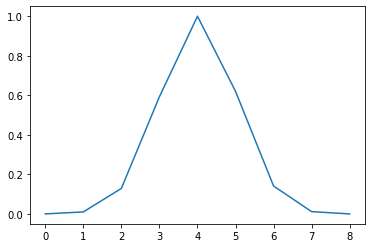

In [204]:
plt.plot(xkernel)
plt.show()

In [198]:
contrib_1d[ix0:ix0 + width] += xkernel

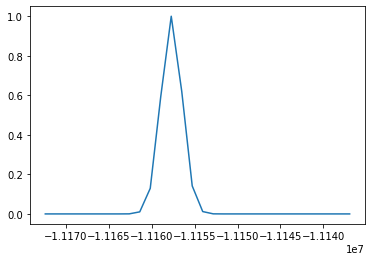

In [205]:
plt.plot(gridx[230:260], contrib_1d[230:260])
plt.show()

### Test 2: Accumulation in 2D

In [206]:
gridy = get_grid1d(bottom_left[1], top_right[1], dg)

In [209]:
len(gridy)

373

In [210]:
testpt = proj_mercator(*data.iloc[13][['LONGITUDE', 'LATITUDE']].values)

Initialize the contributions array

In [212]:
contribs_2d = numpy.zeros((len(gridy), len(gridx)))

In [216]:
contribs_2d.shape

(373, 781)

In [228]:
def add_point(x, y, value):
    # Find the indices of the bottom left corner of the affected area
    ix0 = int(numpy.round((x - gridx[0]) / dg)) - half_width
    iy0 = int(numpy.round((y - gridy[0]) / dg)) - half_width
    
    # Compute the kernel values in X and Y
    xkernel = kernel( (gridx[ix0:ix0 + width] - x) / dg )
    ykernel = kernel( (gridy[iy0:iy0 + width] - y) / dg )
    
    # Add the kernel values to the contributions array, row by row
    for i in range(width):
        rowkernel = xkernel * ykernel[i]
        contribs_2d[iy0 + i,ix0:ix0 + width] += rowkernel
    
    return

In [221]:
[*range(width)]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

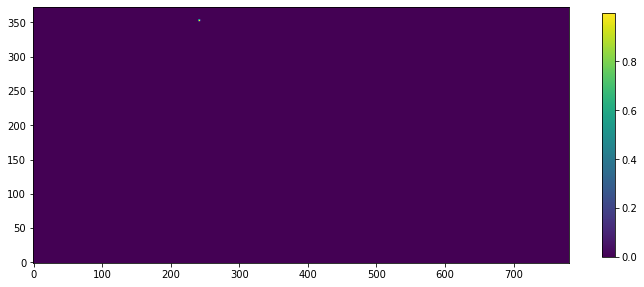

In [244]:
plt.figure(figsize=(12,6))
c1 = plt.imshow(contribs_2d, origin="lower")
plt.colorbar(c1, shrink=0.75)
plt.show()

In [231]:
add_point(testpt[0], testpt[1], 0)

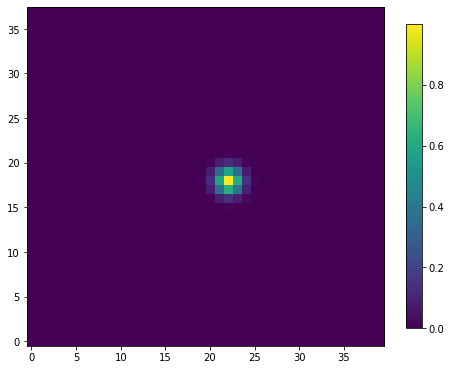

In [249]:
plt.figure(figsize=(8,8))
c1 = plt.imshow(contribs_2d[335:,220:260], origin="lower")
plt.colorbar(c1, shrink=0.7)
plt.show()

### Putting it all together

In [379]:
def grid_data(data, xgrid, ygrid, radius):
    # Initialize output arrays
    ny = len(ygrid)
    nx = len(xgrid)
    values = numpy.zeros((ny, nx))
    density = numpy.zeros((ny, nx))

    # Compute some window sizes in units of grid spacing
    dg = xgrid[1] - xgrid[0]
    halfwin = int( numpy.round(4 * radius / dg) )
    window = 2 * halfwin + 1
    
    def get_window_ends(x, x0, n):
        i0 = int(numpy.round((x - x0) / dg)) - halfwin
        i1 = i0 + window
        return max(0, i0), min(i1, n)
        
    def add_data(x, y, val):
        # Find the indices of the bottom left corner of the affected area
        ix0, ix1 = get_window_ends(x, xgrid[0], nx)
        iy0, iy1 = get_window_ends(y, ygrid[0], ny)
    
        # Compute the kernel values in X and Y
        xkernel = kernel( (xgrid[ix0:ix1] - x) / radius )
        ykernel = kernel( (ygrid[iy0:iy1] - y) / radius )
    
        # Accumulate kernel and kernel * data, row by row
        for i in range(len(ykernel)):
            rowkernel = xkernel * ykernel[i]
            density[iy0 + i,ix0:ix1] += rowkernel
            values[iy0 + i,ix0:ix1] += rowkernel * val

        return
    
    # Loop over data rows, accumulate results
    for index, row in data.iterrows():
        add_data(*row.values)
    
    # Normalize values
    values = numpy.divide(values, density, out=numpy.zeros_like(density), where=density>0.01)
    
    return values, density

Note that the above function requires the data to be pre-projected to Web Mercator.

In [254]:
data.head(2)

,SITE_ID,LONGITUDE,LATITUDE,RIPPABILITY
0,2634,-99.940438,35.616586,4.0
1,2635,-99.936163,35.603896,4.0


In [287]:
data['x'] = data['LONGITUDE'].map(get_mercatorX)

In [289]:
data['y'] = data['LATITUDE'].map(get_mercatorY)

In [290]:
data.head(2)

,SITE_ID,LONGITUDE,LATITUDE,RIPPABILITY,x,y
0,2634,-99.940438,35.616586,4.0,-1.111288e+07,4.243244e+06
1,2635,-99.936163,35.603896,4.0,-1.111241e+07,4.241508e+06


In [295]:
data_strip = data.loc[(data['LONGITUDE'] > -97) & (data['LONGITUDE'] < -96.3)]

In [296]:
data.shape

(121976, 6)

In [297]:
data_strip.shape

(13017, 6)

In [352]:
xyv = pandas.DataFrame({'x': data['x'], 'y': data['y'], 'val': data['RIPPABILITY']})

In [353]:
xyv.shape

(121976, 3)

In [358]:
strip_gridx = get_grid1d(xyv.x.min(), xyv.x.max(), 2 * dg)

In [359]:
strip_gridy = get_grid1d(xyv.y.min(), xyv.y.max(), 2 * dg)

In [380]:
vals, dens = grid_data(xyv, strip_gridx, strip_gridy, 3 * dg)

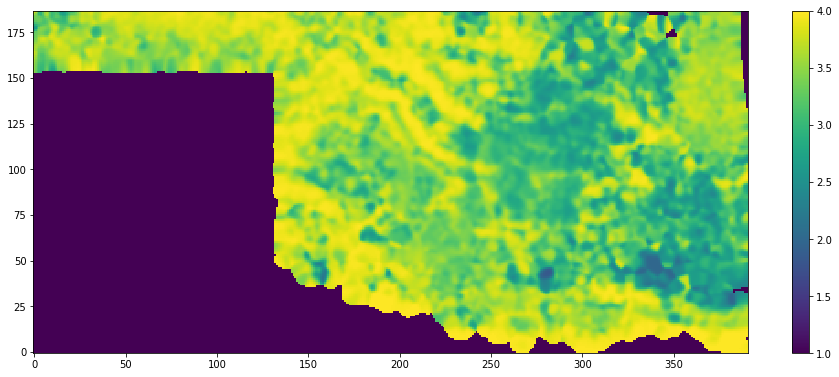

In [381]:
plt.figure(figsize=(16, 9))
c1 = plt.imshow(vals, origin="lower", vmin=1, vmax=4)
plt.colorbar(c1, shrink=0.7)
plt.show()

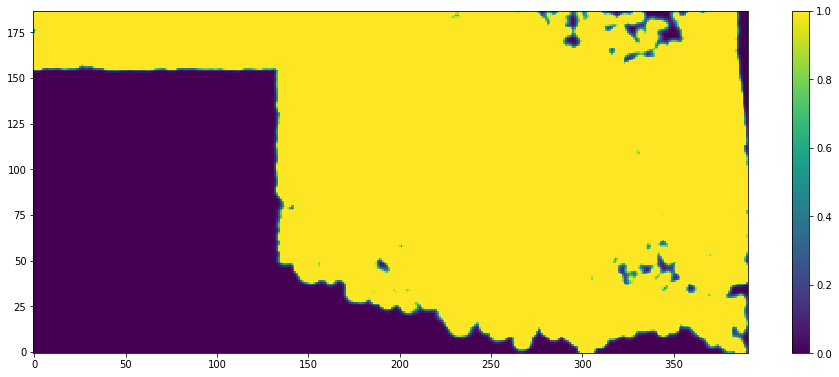

In [386]:
plt.figure(figsize=(16, 9))
c1 = plt.imshow(dens, origin="lower", vmin=0, vmax=1)
plt.colorbar(c1, shrink=0.7)
plt.show()